In [4]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import iapws as IAPWS95
import lvm_read
import tkinter as tk
from tkinter import filedialog

Reading Test Data # 0
Reading Test Data # 1
Reading Test Data # 2
Reading Test Data # 3
Reading Test Data # 4
Reading Test Data # 5
Reading Test Data # 6
Reading Test Data # 7
Reading Test Data # 8
Reading Test Data # 9
Reading Test Data # 10
Reading Test Data # 11
Reading Test Data # 12
Reading Test Data # 13
Reading Test Data # 14
Reading Test Data # 15
Reading Test Data # 16
Reading Test Data # 17
Reading Test Data # 18
Reading Test Data # 19
Reading Test Data # 20
Reading Test Data # 21
Reading Test Data # 22
Reading Test Data # 23
Reading Test Data # 24
Reading Test Data # 25
Reading Test Data # 26
Reading Test Data # 27
Reading Test Data # 28


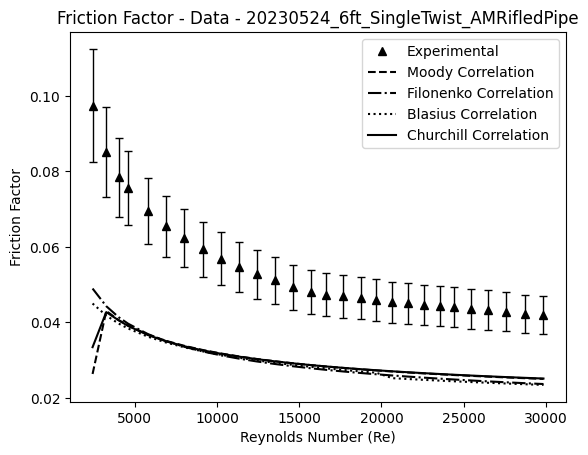

In [5]:
###########################################
## Friction Factor Code                  ##
## Date -                                ##
## Authors -  Ryan McGuire               ##
## Projects - Straight, Twisted, Riffled ##
## Rev - 0                               ##
###########################################

path = r"G:\Shared drives\EGR-Mechanical and Nuclear Engineering-FAST Research Group\Projects\additive_manufacturing\2 _helicalprofile\Data\20230524_6ft_SingleTwist_AMRifledPipe"
figurepath = r"G:\My Drive\Test_Folder"

#Pipe Info
di = 0.02667 #0.0276(6ft SS)                                   #Inner diameter [m]
do = 0.03340                                    #Outer diameter [m]
L_heated = 1.8415                               #Heated Length [m]
#Ai = L*pi*di                                   #surface area inside [m]
L_press =1.8542                                 #6ftAM=1.8542 ##6ftSS=1.8415 ##3ft=0.9335 
                                
roughness= 0.015/1000                     # m, stainless steel absolute roughness converted from mm to m
L_extra=2*0.0445   # m, extra length between pressure taps and test section
PT = 1                                          #if it's 1 = psi : 2 = inches of H20
case = 2                                        #if it's 1 = straight : 2 = rifled: 

##Twisted Tape Dimensions
tt = 0                                          #Twsited Tape Y = 1 N = 0
mix = 0                                         #Mixing Section Y = 1 N = 0
y = 3.62                                        #Twisting pitch
w_TT = 0.02286                                  #Width of twisted tape

##Rifle Dimensions
ri=0.01331                                      #m
theta=0.523599                                  #rad
ro=0.0154                                       #m
f=6                                             #number of fins
h = 0.00209                                     #m

#################################################
#    Dont need to change anything below here    #
#################################################

#root = tk.Tk()
#root.withdraw()
#print("Select the Runs Folder with the LVM files")
#path = filedialog.askdirectory()
#print("Select the Correct Figures Folder")
#figurepath = filedialog.askdirectory()

def WaterProperties(temp,type,units):
    '''
    This function outputs the value of a specific water property based on the type. The inputs are [temp] 
    which is in Degree Celcius, and [type] which tells the code what kind of property to calculate.
    
    Types should be written in string format:
    Density - input: p 
    Kinematic Viscosity: kv
    Dynamic Viscosity: dv
    Thermal Diffusivity: td
    Thermal Conductivity: k 
    
    Working Temperatures : 10 - 100 C at atmospheric pressure 

    Units :  refers to either imperial or si units it has to be a string
    SI = si units
    IP = imperial
    '''

    if units == 'SI': # First if loop : units
        if temp >= 10 and temp <= 100: # Second loop : check temperature applicable
            #Third loop : calculates based on type
            if type == 'p': #Density 
                y1 = -0.003513*(temp**2) - 0.07237*temp +1001
            elif type == 'kv': #Kinematic Viscosity
                y1 = -2.46235*10**(-12)*(temp**3) + 5.5923*10**(-10)*(temp**2) - (4.62972*10**(-8))*temp + 1.77044*10**(-6)
            elif type == 'dv': #Dynamic Viscosity
                y1 = -2.45364*10**(-9)*(temp**3) + 5.50995*10**(-7)*(temp**2) - (4.53234*10**(-5))*temp + 1.72642*10**(-3)
            elif type == 'td': 
                y1 = -(2.09824*10**(-12))*(temp**2) + 5.5971*10**(-10)*temp + 1.33116*10**(-7)
            elif type == 'k':
                y1 = -9.56986*10**(-6)*(temp**2) + 0.0021458*temp + 0.560302
            else: #This case means there was an error in the type
                print('Wrong type')
        else:
            y1 = 0
            print('Wrong temperature range')
    elif units == 'IP':
        y1 = 0
        print('Working on it')
    else:
        print('No such units')
    return y1

def fricfactor(psid1,psid0,errpsi,tt,mix,m,y,Tbulk,L,Tout,w_TT,PT):
    '''
    This code calculates the friciton factor based on pressure drop measurements and calculates corresponding correlations
     
    The inputs:
        psid1 = Pressure Drop from the measurement in PSID
        psid0 = Pressure Drop from the measurement in PSID, the pressure at flow 0
        tt = Twisted tape insert (Yes or No)
        mix = Mixing Section (Yes or No)
        m = flow rate from flow meter (GPM)
        errpsi = standard deviation/sqrt of number of samples
        Tbulk = Bulk temperature (C)
        Twall = Wall temperature (C)
        y = pitch
        L = length 
        Tin = Inlet Temperature (C)
        Tout = Outlet Temperature (C)
        PT = Type of pressure transducer
         
    The outputs:
        FF_sol = solution vector with different outputs depending on the inputs
        FF_sol(1) = Reynolds
        FF_sol(2) = Pr
        FF_sol(3) = Prressure Drop
        FF_sol(4) = Friction Factor
        FF_sol(5) = Error Friction Factor 

    '''
   
    l=theta*ro                                      #arc length
    A_t = np.pi*ri**2+((theta/2)*(ro**2-ri**2))*f         #m^2
    dh = 4*((np.pi*ri**2)+(theta*((ro**2)-(ri**2))*f))/(l+2*f*h-(l*ri/ro)+(2*np.pi*ri))    #hydraulic diameter
    nu = WaterProperties(Tbulk,'kv','SI')           # Kinematic Viscosity [m2/s]
    rho = WaterProperties(Tbulk,'p','SI')
    alpha = WaterProperties(Tbulk,'td','SI')        # Thermal Diffusivity [m2/s]
    M = m*rho/15850                                 # Flow rate in [kg/s]
    u = M/(rho*np.pi*((di/2)**2))                   # Water speed [m/s]
    u_h=M/(rho*A_t)                                 # Water speed within test section [m/s]
    Pr = nu/alpha                                   # Prandlt Number 
    Re = u*di/nu                                    # Reynolds Number
    Re_h = u_h*dh/nu                                # Reynolds Number within test section
    u_m1 = m*0.03                                   # Uncertainty in flow rate [GPM]
    u_m2 = 0.02                                     # Uncertainty in values shown (+-1 percent GPM)
    u_m = np.sqrt(u_m1**2 + u_m2**2)
    u_u = u_m/(15850*np.pi*(di/2)**2)               # Uncertainty in flow rate
    u_uh = u_m/(15850*A_t)                          # Uncertainty in flow rate within test section

    ##Calculating Losses
    K_exp=0#(1-di**2/(1.315*2.54/100)**2)**2         # using correl from table 9-1 of T&K
    K_contr=0#0.15*(1-di**2/(1.315*2.54/100)**2)  # using correl from table 9-1 of T&K
    if PT == 1:
        Factor =6894.8                              #Pressure transducer is in psi
    elif PT == 2:
        Factor = 248.84                             #Pressure transducer is in inches of water
    
    Recrit = 3000
    if Re<Recrit: #Flow is laminar
        fcor = 64/Re 
        dPcor = 0.5*rho*u**2*(L_extra*fcor/di + K_exp + K_contr)/Factor
    else: #Flow is turbulent
        fcor= 0.0055*(1+((20000*roughness/di)+1e6/Re)**(1/3))
        dPcor = 0.5*rho*u**2*(L_extra*fcor/di + K_exp + K_contr)/Factor
    #psid0 = 0
    
    ##Calculation for Pressure Drop
    psid = psid1 - psid0 - dPcor                    #The actual pressure is the pressure reading minus the 0 and minus the losses
    P_Pa = psid*Factor                              #Change pressure to Pa

    #Now accounting for Pressure Loss from the mixing section
    #This is the Darcy Friction Factor Calculation
    #P_Pa = P_Pa0 - Pmix - dPcor
    if case == 1:                                    #Test section is a straight pipe
        #Straight pipe friction factor    
        FF_calc = 2*P_Pa*di/(L*rho*u**2)
        #Straight Pipe friction factor error
        errF = np.sqrt((errpsi*Factor*2*di/(L*rho*u**2))**2 + (4*P_Pa*di*u_u/(L*rho*u**3))**2)
    elif case == 2:                                  #Test section is a rifled pipe
        #AM Rifled pipe friction factor    
        FF_calc = 2*P_Pa*dh/(L*rho*u_h**2)
        #AM Rifled Pipe friction factor error
        errF = np.sqrt((errpsi*Factor*2*dh/(L*rho*u_h**2))**2 + (4*P_Pa*dh*u_uh/(L*rho*u_h**3))**2)



    FF_sol = np.zeros(13)
    FF_sol[0] = Re
    FF_sol[1] = Pr
    FF_sol[2] = P_Pa
    FF_sol[3] = FF_calc
    FF_sol[4] = errF

    if tt == 0:
        #This means there is no twisted tape and friciton factor correlations
        #are going to be calculated based on this
        #Moody Correlation:
        # if Re <Recrit:
        #     #Flow is laminar
        #     moody=64/Re
        # else: 
        #     #Flow is turbulent
        #     moody = 0.0055*(1+(20000*roughness/di+1e6/Re)**(1/3))
        moody = fcor
        FF_sol[5] = moody      #Moody Correlation
        filonenko = (0.79*np.log(Re)-1.64)**(-2)
        if Re<=2*10**4:
            blasius = 0.316*Re**(-1/4)
        else:
            blasius = 0.184*Re**(-1/5)

        A=(0.8687*np.log(1/((0.883*(np.log(Re))**1.282)/(Re**1.007)+.27*(roughness/di)+(110*(roughness/di)/Re))))**16
        B=(13269/Re)**16
        churchill=((64/Re)**12+(A+B)**(-3/2))**(1/12)

        FF_sol[6] = filonenko
        FF_sol[7] = blasius
        FF_sol[8] = churchill
        FF_sol[9] = u 
        FF_sol[10] = psid1
        FF_sol[11] = psid0
        FF_sol[12] = nu
    else:
        #This means there is a twisted tape in the pipe and friction factor
        #correlations will be calculated based on this
        # First Manglik and Bergles:
        pitch = y
        t_TT=0.0625*25.4/1000 #m, thickness of tape
        #w_TT=1*25.4/1000 #m, width of tape
        diam = di
        #turbulent correlation
        fMBturb=4*0.0791/(Re**0.25)*(np.pi/(np.pi-4*t_TT/diam))**1.75*((np.pi+2-2*t_TT/diam)/(np.pi-4*t_TT/diam))**1.25*(1+2.752/pitch**1.29)
    
        #laminar correlation
        Sw=Re*(np.pi/(np.pi-4*t_TT/diam))*(1+(np.pi/2/pitch)**2)**(1/2)/np.sqrt(pitch)
        fMBlam=4*15.767/Re*(1+1e-6*Sw**2.55)**(1/6)*(1+(np.pi/2/pitch)**2)*(np.pi/(np.pi-4*t_TT/diam))*((np.pi+2-2*t_TT/diam)/(np.pi-4*t_TT/diam))**2
        fCalc=4*0.0791/(Re**0.25)*(np.pi/(np.pi-4*t_TT/di))**1.75*((np.pi+2-2*t_TT/di)/(np.pi-4*t_TT/di))**1.25*(1+2.752/pitch**1.29)
        #now do asymptotic matching
        fCalc=(fMBturb**10+fMBlam**10)**(1/10)
        FF_sol[5] = fCalc
    
    #Now to calculate using filonenko
    #Channel flow calculations:
        Axs_TT=np.pi*di**2/4-(t_TT*w_TT) #m2
        Pwet_TT=np.pi*di+2*w_TT+t_TT #m
        DhTT=4*Axs_TT/Pwet_TT #m
        k = np.pi/(2*y)
        Lstar = L*np.sqrt(1+k**2)
        vstar = m/(15850*Axs_TT)*np.sqrt(1+k**2)
        Restar = vstar*DhTT/nu
        u_vstar = u_m/(15850*Axs_TT)*np.sqrt(1+k**2)
    
    #Calculating:
        FFstar = 2*P_Pa*DhTT/(Lstar*rho*vstar**2)
        errFstar = np.sqrt((errpsi*6894.7*2*DhTT/(Lstar*rho*vstar**2))**2 + (4*P_Pa*DhTT*u_vstar/(Lstar*rho*vstar**3))**2)
    
    #Adding to Solution Matrix:
        FF_sol[6] = Restar
        FF_sol[7] = FFstar
        FF_sol[8] = errFstar
    
    #Correlations:
        FF_fil = (1.82*np.log10(Restar)-1.64)**-2     #Filonenko Correlation
        FF_sol[9] = FF_fil
    
    return FF_sol

#Obtain folder
folder = os.chdir(path)
path= os.getcwd()
lvm_files = sorted(glob.glob(os.path.join(path, "*.lvm")))
num_files = len(lvm_files)              
N_FF = np.empty((13,1))
N_FFa = ['Re','Pr','P_Pa','Ff_calc','errF','Moody','Filoenko','Blasius','Churchill','U','psid1','psid0','nu']

#Get Mflows from Excel
mflowsarray = []
with open('TestMatrix.csv', 'r') as csv_file:
    for row in csv_file:
        values = row.strip().split(',')
        try:
            value = float(values[3])
            mflowsarray.append(value)
        except ValueError:
            continue
mflows = np.array(mflowsarray)

## Calculate Pressure Drop
##Zero Reading
print('Reading Test Data # 0')
data = lvm_read.read(lvm_files[0],read_from_pickle=False,dump_file=False)
mydata=np.array(data[0]['data']) # Assigining the data from the lvm file
N=len(mydata)
df=pd.DataFrame(mydata,columns=['Time','TinA','ToutB','PSID']) #Creating a dataframe for the data
pzero=df['PSID'].mean() #Determining the initial pressure drop in the system with no flow
stpdrop=df['PSID'].std() # Standard Deviation of the pressure drop in each test
t1=df['TinA'].mean() #Determining the initial pressure drop in the system with no flow
t2=df['ToutB'].mean()
tzero=(t2+t1)/2
ep0=stpdrop/(N**5) # Standard Deviation / sqrt(number of samples)
##Data Reading
for x in range(1,num_files):
    print('Reading Test Data #',x)
    mydata=[] #Reinitializing the array
    data=lvm_read.read(lvm_files[x],read_from_pickle=False, dump_file=False) # Reading the xth test data ##future_note
    mydata=np.array(data[0]['data']) # Assigining the data from the lvm file
    df=pd.DataFrame(mydata,columns=['Time','TinA','ToutB','PSID']) #Creating a dataframe for the data
    pressured=df['PSID'].mean() # Determining the pressure drop in the system during the test
    t1=df['TinA'].mean()
    t2=df['ToutB'].mean()
    Tbulk=(t2+t1)/2
    stpdrop=df['PSID'].std() # Standard Deviation of the pressure drop in each test
    epsi=stpdrop/(N**5) # Standard Deviation / sqrt(number of samples)
    m=mflows[x-1]
    N_FFx = fricfactor(pressured,pzero,epsi,tt,mix,m,y,Tbulk,L_press,t2,w_TT,PT)
    N_FFa = np.vstack((N_FFa,N_FFx))
    N_FFx=N_FFx.reshape((13, 1))
    N_FF=np.concatenate((N_FF, N_FFx), axis=1)
    

with open('Data.csv', 'w',newline="") as f:
    mywriter = csv.writer(f, delimiter=',')
    mywriter.writerows(N_FFa)

folder = os.path.basename(os.getcwd())
parent_folder = os.path.basename(os.path.dirname(os.getcwd()))

fig1 = plt.figure()
plt.plot(N_FF[0][1:],N_FF[3][1:],'k^',label='Experimental')
plt.plot(N_FF[0][1:],N_FF[5][1:],'k--',label='Moody Correlation') #y-
plt.plot(N_FF[0][1:],N_FF[6][1:],'k-.',label='Filonenko Correlation') #g-
plt.plot(N_FF[0][1:],N_FF[7][1:],'k:',label='Blasius Correlation') #r-
plt.plot(N_FF[0][1:],N_FF[8][1:],'k-',label='Churchill Correlation') #c-
plt.errorbar(N_FF[0][1:],N_FF[3][1:],2*N_FF[4][1:], ls='none',fmt='k',linewidth=1,capsize=3)
plt.legend(loc='best')
#plt.xlim(0,20000)
#plt.ylim(0.0,0.05)
plt.title("Friction Factor - " + parent_folder +" - "+ folder)
plt.xlabel('Reynolds Number (Re)')
plt.ylabel('Friction Factor')
plt.savefig(parent_folder + "_"+ folder + ".png")
os.chdir(figurepath)
plt.savefig(parent_folder + "_"+ folder + ".png")
plt.show()